# GlobalHumanTree mutational spectra analitics

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial

from mutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from mutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from mutspec.io import read_genbank_ref
from mutspec.draw.mut import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()
coda = CodonAnnotation(2)

Format is self-explanatory. It is reasonalbe to apply common logic filters: (i) in both ancestral and derived 5 nucleotide windows there are only A T G C (ii) only Syn (iii) may be you have more filters..

first == ancestral node; second == derived node. if derived node consists of number only it means this node is internal (if there are Letters - external). For now I recomend to work with ALL nodes, but in the near future we will ask the same question (12Syn, 192Syn) separately for internal nodes and separately for external. So it is good to keep it in the pocket.

## Load human global tree mutation dataset (observed)

In [6]:
path_to_muts = "../data/external/fulltreeCodons.csv"
if not os.path.exists(path_to_muts):
    path_to_muts = "https://raw.githubusercontent.com/polarsong/mtDNA_mutspectrum/human-global-tree/Body/3Results/fulltreeCodons.csv"
mut_raw = pd.read_csv(path_to_muts, sep=";")
mut_raw.head()

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,synonymous,ancestral_aa,derived_aa,note
0,28409,AM_PR_0048,174,150,ttTc-,ttCc-,C,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding
1,28409,AM_PR_0048,593,522,acTc-,acAc-,A,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding
2,28409,AM_PR_0048,5007,4840,ctAac,ctGac,G,mRNA_ND2,4469.0,1.0,non-synonymous,Asn,Asp,normal
3,28409,AM_PR_0048,7971,7774,ccGtc,ccRtc,G,mRNA_COX2,7585.0,2.0,non-synonymous,Arg,Ambiguous,normal
4,28409,AM_PR_0048,8017,7820,ccCat,ccMat,C,mRNA_COX2,7585.0,3.0,synonymous,Pro,Pro,normal


### Extend features

In [9]:
mut = mut_raw.rename(columns={"synonymous": "is_syn"})
mut["is_syn"] = mut["is_syn"].map({"non-synonymous": 0, "synonymous": 1}).astype(np.float16)
mut["is_leaf"] = (~mut.second.str.contains("^\d+$")).astype(np.int8)
mut["is_cds"] = mut.gene_info.str.contains("mRNA").astype(np.int8)

mut["Mut"] = mut["ancestor"].str.get(1) + "[" + mut["ancestor"].str.get(2) + ">" + mut["descendant"].str.get(2) + "]" + mut["descendant"].str.get(3)
mut["Mut"] = mut["Mut"].str.upper()

In [10]:
def _extract_codon(ser: pd.Series, cxt_column):
    "extract codon from 2 columns: `cxt_column` and pos_in_codon"
    if ser.pos_in_codon in {1,2,3}:
        cxt = ser[cxt_column]
        cdn_start = 2 - int(ser.pos_in_codon) + 1
        cdn = cxt[cdn_start: cdn_start + 3].upper()
        return cdn
    else:
        return np.nan

mut["ref_cdn"] = mut.apply(partial(_extract_codon, cxt_column="ancestor"),   axis=1)
mut["alt_cdn"] = mut.apply(partial(_extract_codon, cxt_column="descendant"), axis=1)
mut["ref_aa"] = mut["ref_cdn"].apply(coda.translate_codon)
mut["alt_aa"] = mut["alt_cdn"].apply(coda.translate_codon)
mut["IsSyn"] = (mut["ref_aa"] == mut["alt_aa"]).astype(np.int8)

In [11]:
mut.head()

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,...,derived_aa,note,is_leaf,is_cds,Mut,ref_cdn,alt_cdn,ref_aa,alt_aa,IsSyn
0,28409,AM_PR_0048,174,150,ttTc-,ttCc-,C,D-loop_2,NaN,NaN,...,NaN,non-coding,1,0,T[T>C]C,NaN,NaN,NaN,NaN,0
1,28409,AM_PR_0048,593,522,acTc-,acAc-,A,D-loop_2,NaN,NaN,...,NaN,non-coding,1,0,C[T>A]C,NaN,NaN,NaN,NaN,0
2,28409,AM_PR_0048,5007,4840,ctAac,ctGac,G,mRNA_ND2,4469.0,1.0,...,Asp,normal,1,1,T[A>G]A,AAC,GAC,N,D,0
3,28409,AM_PR_0048,7971,7774,ccGtc,ccRtc,G,mRNA_COX2,7585.0,2.0,...,Ambiguous,normal,1,1,C[G>R]T,CGT,CRT,R,*,0
4,28409,AM_PR_0048,8017,7820,ccCat,ccMat,C,mRNA_COX2,7585.0,3.0,...,Pro,normal,1,1,C[C>M]A,CCC,CCM,P,*,0


## Explore mut dataset

In [12]:
len(set(mut["first"]).union(set(mut["second"])))

105980

In [13]:
mut.gene_info.value_counts()

D-loop_1          114760
D-loop_2           78661
mRNA_ND5           51977
mRNA_CYTB          37105
mRNA_COX1          35396
mRNA_ND4           33257
mRNA_ND2           31506
mRNA_ND1           26847
mRNA_ATP6          23331
rRNA_RNR2          20396
mRNA_COX3          20272
mRNA_COX2          17713
rRNA_RNR1          16983
mRNA_ND6           15439
mRNA_ND3           10153
mRNA_ND4L           5820
mRNA_ATP8           5177
tRNA_TRNT           4416
tRNA_TRNC           1842
mRNA_ATP8&ATP6      1787
tRNA_TRNS2          1534
tRNA_TRNH           1459
Spacer3             1424
tRNA_TRNA           1394
tRNA_TRNF           1367
tRNA_TRNG           1367
tRNA_TRNW           1294
Spacer7             1250
tRNA_TRNR           1244
tRNA_TRNQ           1229
tRNA_TRNK           1147
tRNA_TRNE           1025
tRNA_TRND           1022
None                 967
tRNA_TRNL2           836
tRNA_TRNM            772
tRNA_TRNI            713
tRNA_TRNP            661
tRNA_TRNS1           560
Spacer4              511


## Filter mutations
- only syn
- without ambigous nucleotides in pentanucl context
- without ND6
- only one mutation in pentanucleotide context

In [14]:
muts_filtered = mut[
    (mut.is_syn == 1) &
    (mut.ancestor.str.contains("[acgt]{2}[ACGT][acgt]{2}")) &
    (mut.descendant.str.contains("[acgt]{2}[ACGT][acgt]{2}")) &
    (~mut.gene_info.str.contains("ND6")) &
    (mut.apply(lambda x: sum([x != y for x, y in zip(x.ancestor, x.descendant)]) == 1, axis=1))
]
print("Mut numbers:", mut.shape[0])
print("After filtration:", muts_filtered.shape[0])
muts_filtered.head()

Mut numbers: 577276
After filtration: 103281


,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,...,derived_aa,note,is_leaf,is_cds,Mut,ref_cdn,alt_cdn,ref_aa,alt_aa,IsSyn
14,17837,EU_IT_0648,3642,3482,gaAcc,gaGcc,G,mRNA_ND1,3306.0,3.0,...,Glu,normal,1,1,A[A>G]C,GAA,GAG,E,E,1
20,6484,EU_GB_0203,8826,8598,ttTta,ttCta,C,mRNA_ATP6,8526.0,3.0,...,Phe,normal,1,1,T[T>C]T,TTT,TTC,F,F,1
22,6484,EU_GB_0203,14184,13942,caCaa,caTaa,C,mRNA_ND5,12336.0,3.0,...,His,normal,1,1,A[C>T]A,CAC,CAT,H,H,1
26,15298,11475,12801,12560,caAct,caGct,G,mRNA_ND5,12336.0,3.0,...,Gln,normal,0,1,A[A>G]C,CAA,CAG,Q,Q,1
29,33133,7947,3555,3395,taCat,taTat,T,mRNA_ND1,3306.0,3.0,...,Tyr,normal,0,1,A[C>T]A,TAC,TAT,Y,Y,1


In [15]:
muts_filtered.columns

Index(['first', 'second', 'position', 'ref_pos', 'ancestor', 'descendant',
       'nuc_ref_in_ali', 'gene_info', 'gene_start', 'pos_in_codon', 'is_syn',
       'ancestral_aa', 'derived_aa', 'note', 'is_leaf', 'is_cds', 'Mut',
       'ref_cdn', 'alt_cdn', 'ref_aa', 'alt_aa', 'IsSyn'],
      dtype='object')

In [18]:
muts_filtered.to_csv("../data/interim/mutations_syn.csv", index=None)

### Old annotation is correct

In [16]:
np.all(muts_filtered.is_syn == muts_filtered.IsSyn)

True

### Explore filtered mut dataset

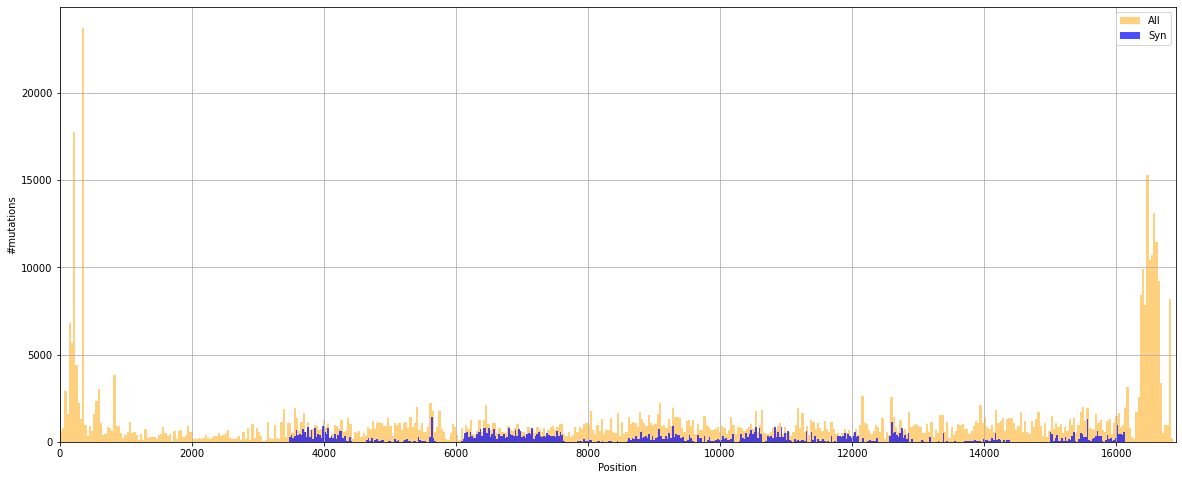

In [69]:
plt.figure(figsize=(20, 8))
mut.position.hist(bins=500, alpha=0.5, label="All", color="orange")
muts_filtered.position.hist(bins=500, alpha=0.7, label="Syn", color="b")
# plt.yscale("log")
plt.xlim(0, 16900)
plt.xlabel("Position")
plt.ylabel("#mutations")
plt.legend()
plt.show()

In [70]:
muts_filtered.pos_in_codon.value_counts()

3.0    96293
1.0     6988
Name: pos_in_codon, dtype: int64

In [71]:
muts_filtered.is_leaf.value_counts()

1    62571
0    40710
Name: is_leaf, dtype: int64

In [72]:
muts_filtered.derived_aa.value_counts()

Leu     20609
Ser      8783
Pro      7976
Gly      6512
Ala      5814
Stop     5651
Thr      5430
Tyr      4562
Glu      4553
Ile      4298
His      4242
Met      4019
Val      3659
Trp      3281
Gln      3185
Asn      2981
Lys      2759
Phe      2676
Asp      1095
Arg       701
Cys       495
Name: derived_aa, dtype: int64

In [75]:
muts_filtered.gene_info.value_counts()

mRNA_COX1         26077
mRNA_ND1          15622
mRNA_CYTB         12685
mRNA_ND5           9446
mRNA_ND4           9106
mRNA_ATP6          8186
mRNA_ND3           6142
mRNA_ND4L          4731
mRNA_COX3          4441
mRNA_ND2           4322
mRNA_ATP8          1188
mRNA_COX2           917
mRNA_ATP8&ATP6      414
mRNA_ND4L&ND4         4
Name: gene_info, dtype: int64

In [76]:
muts_filtered.Mut.value_counts().head(10)

A[G>A]C    4392
C[T>C]T    4324
A[A>G]C    4225
C[C>T]T    4062
A[T>C]T    4009
A[C>T]T    3726
C[G>A]C    3199
T[G>A]C    3122
T[A>G]C    2993
C[A>G]C    2976
Name: Mut, dtype: int64

In [77]:
muts_filtered.Mut.value_counts().tail(10)

C[G>C]G    4
G[C>G]T    4
G[A>T]A    4
G[G>C]T    4
T[C>G]G    4
G[T>G]A    4
G[G>C]C    4
G[T>A]A    2
G[A>T]T    2
G[T>A]T    2
Name: Mut, dtype: int64

## Load saved filtered mutations

In [2]:
muts_filtered = pd.read_csv("../data/interim/mutations_syn.csv")
muts_filtered["Label"] = 1
muts_filtered.head(2)

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,...,note,is_leaf,is_cds,Mut,ref_cdn,alt_cdn,ref_aa,alt_aa,IsSyn,Label
0,17837,EU_IT_0648,3642,3482,gaAcc,gaGcc,G,mRNA_ND1,3306.0,3.0,...,normal,1,1,A[A>G]C,GAA,GAG,E,E,1,1
1,6484,EU_GB_0203,8826,8598,ttTta,ttCta,C,mRNA_ATP6,8526.0,3.0,...,normal,1,1,T[T>C]T,TTT,TTC,F,F,1,1


## Calculate expected mutations for Human mtDNA (all, syn, genes)

In [3]:
# Read reference genbank
path_to_ref = "../data/processed/ref_annot.csv"
Ref = pd.read_csv(path_to_ref)
prot_ref = Ref[(Ref.Type == "CDS") & (Ref.Strand == 1)]

print(prot_ref.shape)
prot_ref.head(4000)

(10816, 10)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
3306,3307,A,CAT,1,CDS,ND1,1,1,ATA,11741.0
3307,3308,T,ATA,1,CDS,ND1,2,2,ATA,11743.0
3308,3309,A,TAC,1,CDS,ND1,3,3,ATA,11745.0
3309,3310,C,ACC,1,CDS,ND1,4,1,CCC,11747.0
3310,3311,C,CCC,1,CDS,ND1,5,2,CCC,11749.0
...,...,...,...,...,...,...,...,...,...,...
8040,8041,A,TAA,1,CDS,COX2,456,3,ATA,4486.0
8041,8042,A,AAT,1,CDS,COX2,457,1,ATA,4488.0
8042,8043,T,ATA,1,CDS,COX2,458,2,ATA,4490.0
8043,8044,A,TAA,1,CDS,COX2,459,3,ATA,4492.0


In [23]:
exp_muts12 = dict()
exp_muts192 = dict()
for gene, gtable in prot_ref[prot_ref.Codon.str.len() == 3].groupby("GeneName"):
    assert np.all(gtable.PosInGene == np.arange(1, gtable.shape[0] + 1))
    seq = gtable.Nuc.values
    gene_exp_muts12, gene_exp_muts192 = coda.collect_exp_mut_freqs(seq, labels=["syn"])
    for lbl in gene_exp_muts12:
        if lbl not in exp_muts12:
            exp_muts12[lbl] = defaultdict(int)
            exp_muts192[lbl] = defaultdict(int)

        for sbs, _cnt in gene_exp_muts12[lbl].items():
            exp_muts12[lbl][sbs] += _cnt
        for sbs, _cnt in gene_exp_muts192[lbl].items():
            exp_muts192[lbl][sbs] += _cnt

        # if lbl == "syn":
        #     exp_muts12[lbl + "_" + gene] = gene_exp_muts12[lbl]
        #     exp_muts192[lbl + "_" + gene] = gene_exp_muts192[lbl]

for lbl in ["D-loop", "rRNA", "tRNA"]:
    f1, f2 = coda.collect_exp_mut_freqs(Ref[Ref.Type == lbl]["Nuc"].values, ["all"])
    exp_muts12[lbl], exp_muts192[lbl] = f1["all"], f2["all"]

lbl = "ExDloop"
f1, f2 = coda.collect_exp_mut_freqs(Ref[(~Ref.Type.isin(["D-loop", "misc_feature"]))]["Nuc"].values, ["all"])
exp_muts12[lbl], exp_muts192[lbl] = f1["all"], f2["all"]

In [24]:
pd.DataFrame(exp_muts192).sort_index()

,syn,D-loop,rRNA,tRNA,ExDloop
A[A>C]A,NaN,30,113,78.0,494
A[A>C]C,NaN,32,84,51.0,463
A[A>C]G,NaN,13,69,40.0,196
A[A>C]T,NaN,21,50,41.0,355
A[A>G]A,78.0,30,113,78.0,494
...,...,...,...,...,...
T[T>C]T,47.0,20,32,44.0,231
T[T>G]A,34.0,18,56,52.0,311
T[T>G]C,28.0,15,26,27.0,293
T[T>G]G,11.0,12,22,14.0,104


## Calculate MutSpec

### Full tree

In [7]:
muts_filtered["Label"] = 1
ms192 = calculate_mutspec(muts_filtered, exp_muts192["syn"], use_context=True)
ms12 = calculate_mutspec(muts_filtered, exp_muts12["syn"], use_context=False)

# Reverse complement of Mut (to heavy strand) is unneded
# ms192["Mut"] = ms192.Mut.apply(rev_comp)
# ms12["Mut"] = ms12.Mut.str.translate(translator)
ms192.sort_values("Mut", inplace=True)
ms12.sort_values("Mut", inplace=True)

ms12.to_csv("../data/mutspecs_human_global_tree/human_global_tree_mutspec12syn.csv", index=None)
ms192.to_csv("../data/mutspecs_human_global_tree/human_global_tree_mutspec192syn.csv", index=None)

In [8]:
ms12 = pd.read_csv("../data/mutspecs_human_global_tree/human_global_tree_mutspec12syn.csv")
ms192 = pd.read_csv("../data/mutspecs_human_global_tree/human_global_tree_mutspec192syn.csv")

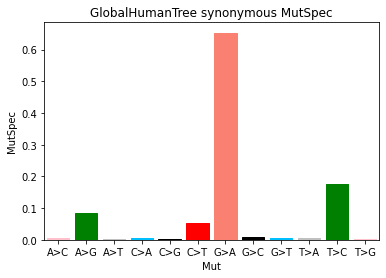

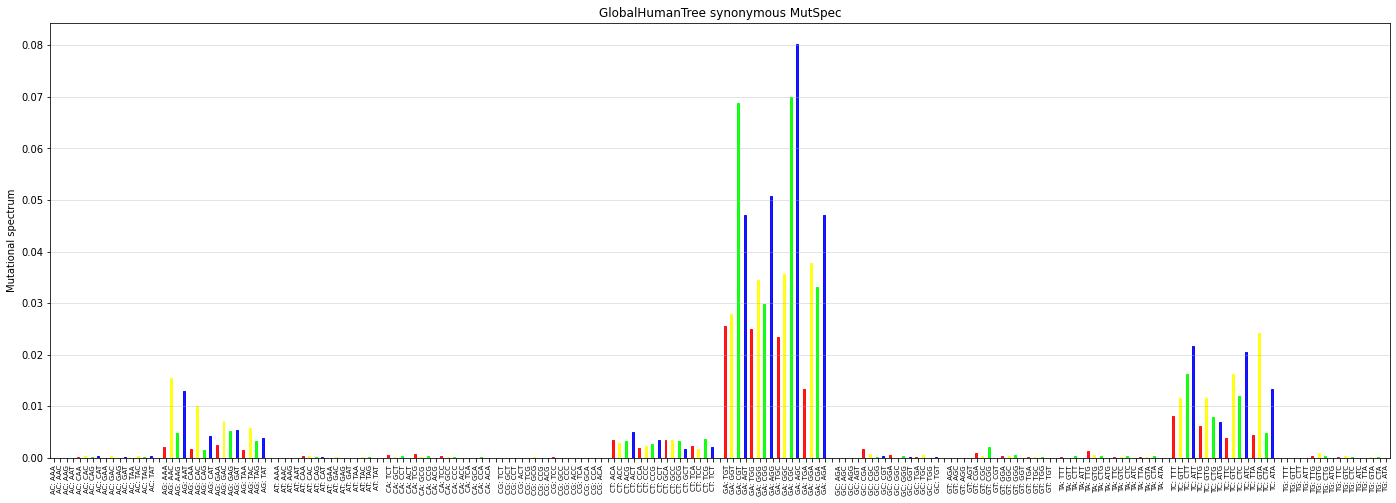

In [13]:
plot_mutspec12(ms12, title="GlobalHumanTree synonymous MutSpec",   savepath="../data/mutspecs_human_global_tree/human_global_tree_mutspec12syn.pdf")
plot_mutspec192kk(ms192, title="GlobalHumanTree synonymous MutSpec", filepath="../data/mutspecs_human_global_tree/human_global_tree_mutspec192syn.pdf")

### Only leaves

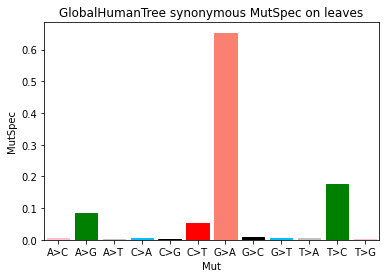

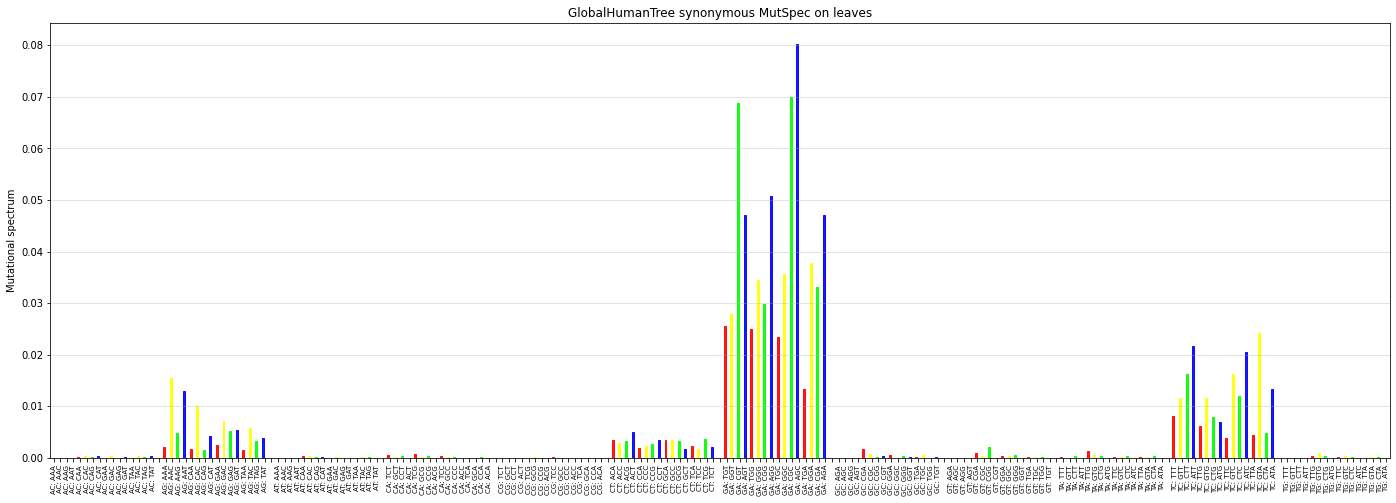

In [12]:
ms192 = calculate_mutspec(muts_filtered[muts_filtered.is_leaf == 1], exp_muts192["syn"], use_context=True)
ms12 = calculate_mutspec(muts_filtered[muts_filtered.is_leaf == 1], exp_muts12["syn"], use_context=False)

# Reverse complement of Mut (to heavy strand)
# ms192["Mut"] = ms192.Mut.apply(rev_comp)
# ms12["Mut"] = ms12.Mut.str.translate(translator)
ms192.sort_values("Mut", inplace=True)
ms12.sort_values("Mut", inplace=True)

ms12.to_csv( "../data/mutspecs_human_global_tree/human_global_tree_mutspec12syn_leaves.csv", index=None)
ms192.to_csv("../data/mutspecs_human_global_tree/human_global_tree_mutspec192syn_leaves.csv", index=None)

plot_mutspec12(ms12,   title="GlobalHumanTree synonymous MutSpec on leaves", savepath="../data/mutspecs_human_global_tree/human_global_tree_mutspec12syn_leaves.pdf")
plot_mutspec192kk(ms192, title="GlobalHumanTree synonymous MutSpec on leaves", filepath="../data/mutspecs_human_global_tree/human_global_tree_mutspec192syn_leaves.pdf")

## TSSS

Comparison of the 6-8 and 14-16 in GlobalTree (where differences are significant). This is where Bogdan’s confirmation is most needed. 

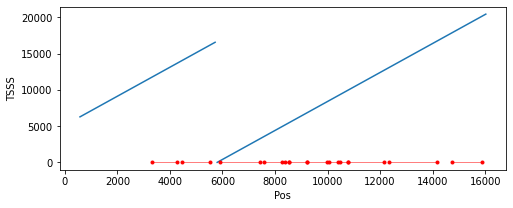

In [4]:
plt.figure(figsize=(8, 3))
plt.plot(Ref.Pos, Ref.TBSS)
for gn in prot_ref.GeneName.unique():
    pmin = prot_ref[prot_ref.GeneName == gn].Pos.min()
    pmax = prot_ref[prot_ref.GeneName == gn].Pos.max()
    plt.plot([pmin, pmax], [0, 0], "r.-", linewidth=0.5)
plt.ylabel("TSSS")
plt.xlabel("Pos")
plt.show()

In [5]:
# prot_ref.groupby("GeneName").Pos.apply(lambda x: {"min": x.min(), "max": x.max()}).sort_values()

In [6]:
def get_exp_mut_freqs_syn(pos_min, pos_max, lbl="syn"):
    _pic_col_idx = list(prot_ref.columns).index("PosInCodon")
    cur_ref = prot_ref[(prot_ref.Pos >= pos_min) & (prot_ref.Pos <= pos_max)]

    pic_first = cur_ref.iloc[0].PosInCodon
    pic_last  = cur_ref.iloc[-1].PosInCodon
    pos_min = cur_ref.Pos.min() - pic_first + 1
    pos_max = cur_ref.Pos.max() + 3 - pic_last
    print(f"Adjusted potitions: {pos_min}, {pos_max}")
    cur_ref = prot_ref[(prot_ref.Pos >= pos_min) & (prot_ref.Pos <= pos_max)]
    # return cur_ref
    # assert cur_ref.iloc[0].PosInCodon == 1
    # assert cur_ref.iloc[-1].PosInCodon == 3

    exp_muts12, exp_muts192 = defaultdict(int), defaultdict(int)
    for gn, df in cur_ref.groupby("GeneName"):
        seq = df.Nuc.values
        gene_exp_muts12, gene_exp_muts192 = coda.collect_exp_mut_freqs(seq, labels=[lbl])

        for sbs, _cnt in gene_exp_muts12[lbl].items():
            exp_muts12[sbs] += _cnt
        for sbs, _cnt in gene_exp_muts192[lbl].items():
            exp_muts192[sbs] += _cnt
    
    return exp_muts12, exp_muts192

### 6-8k

Adjusted potitions: 6000, 8002
Number of mutations: 15378


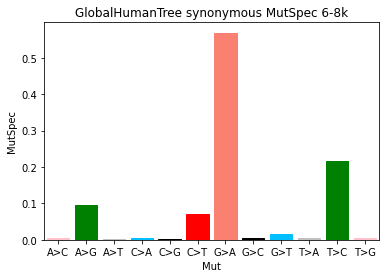

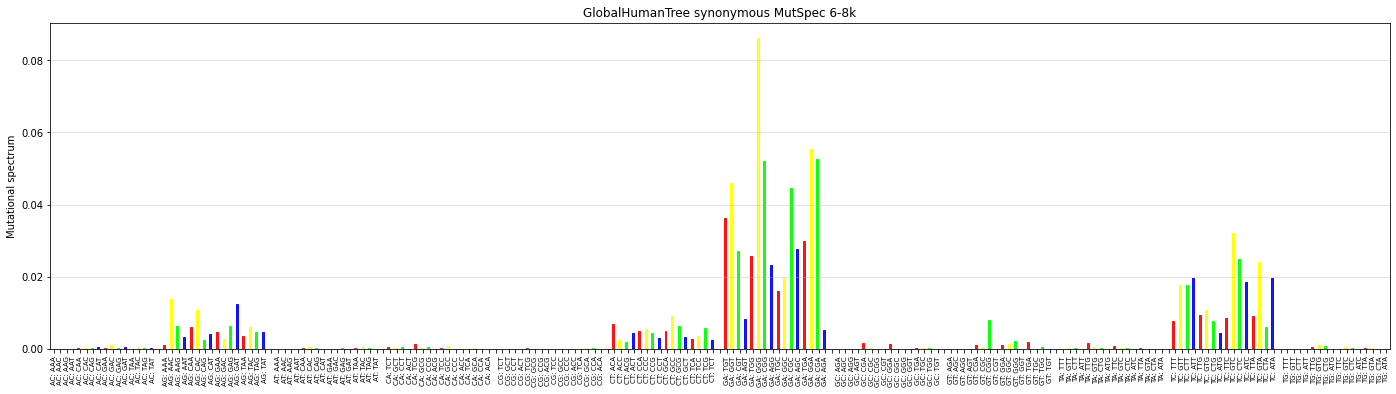

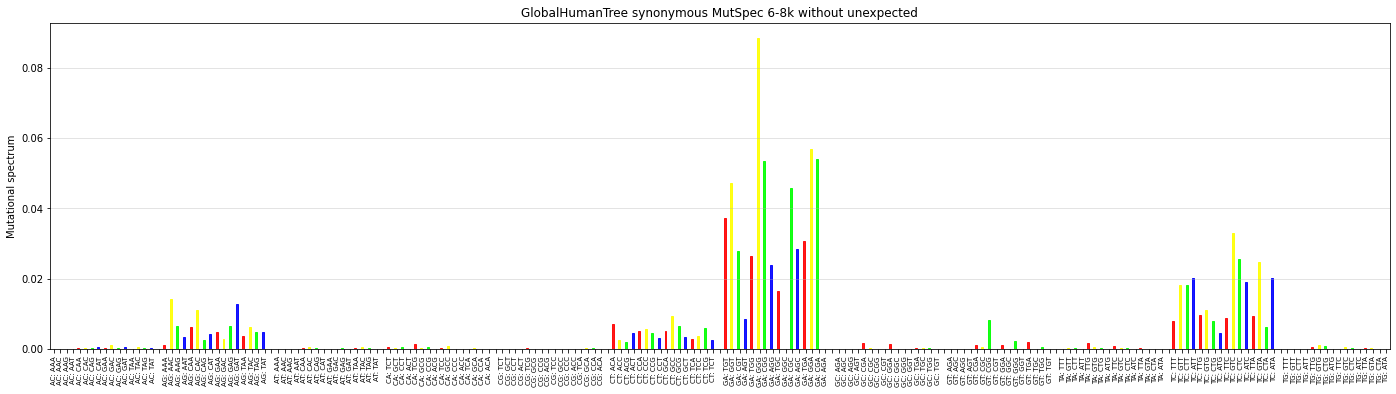

In [19]:
pmin, pmax = 6000, 8000

exp_muts12, exp_muts192 = get_exp_mut_freqs_syn(pmin, pmax)
# replace 'ref_pos' to "position"
obs_muts = muts_filtered[(muts_filtered.ref_pos >= pmin) & (muts_filtered.ref_pos <= pmax) & (muts_filtered.is_leaf == 1)]
print("Number of mutations:", obs_muts.shape[0])
ms12 = calculate_mutspec(obs_muts, exp_muts12)
ms192 = calculate_mutspec(obs_muts, exp_muts192, use_context=True)

ms12.to_csv(f"../data/processed/GlobalHumanTree/mutspec12syn_leaves{pmin//1000}-{pmax//1000}k.csv", index=None)
ms192.to_csv(f"../data/processed/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k.csv", index=None)

plot_mutspec12(ms12, title=f"GlobalHumanTree synonymous MutSpec {pmin//1000}-{pmax//1000}k", 
    savepath=f"../figures/GlobalHumanTree/mutspec12syn_leaves{pmin//1000}-{pmax//1000}k.pdf")
plot_mutspec192kk(ms192, title=f"GlobalHumanTree synonymous MutSpec {pmin//1000}-{pmax//1000}k", 
    filepath=f"../figures/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k.pdf")

ms192["RawMutSpec"] = (ms192["ObsFr"] / ms192["ExpFr"]).fillna(0).replace(np.inf, 0)
ms192["MutSpec"] = ms192["RawMutSpec"] / ms192["RawMutSpec"].sum()
plot_mutspec192kk(ms192, title=f"GlobalHumanTree synonymous MutSpec {pmin//1000}-{pmax//1000}k without unexpected",
    filepath=f"../figures/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k_without_unexpected.pdf")

### 14-16k

Adjusted potitions: 13999, 15889
Number of mutations: 8015


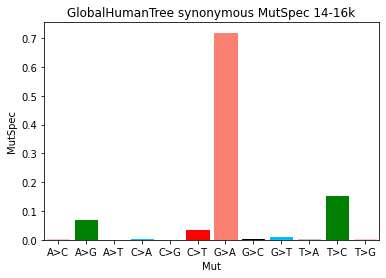

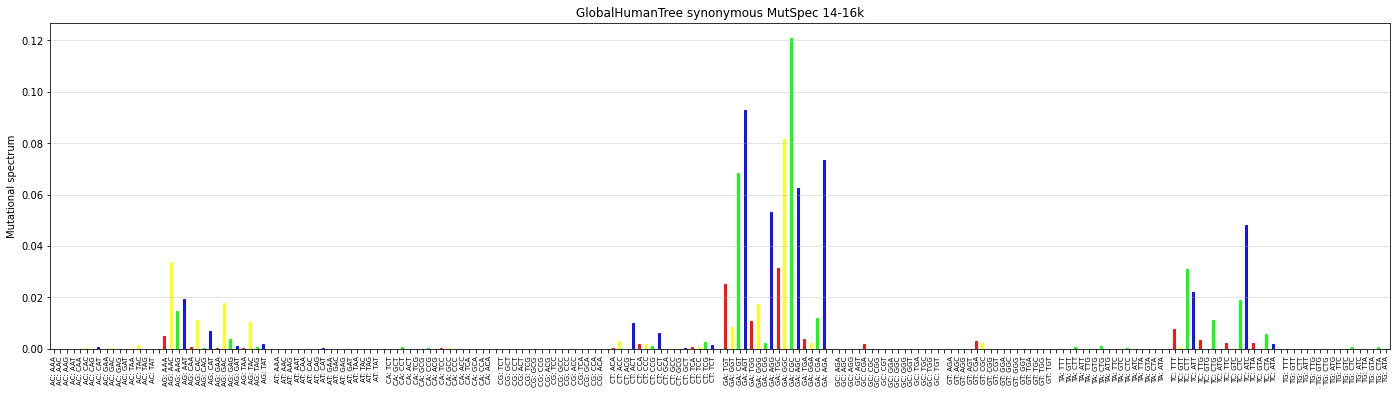

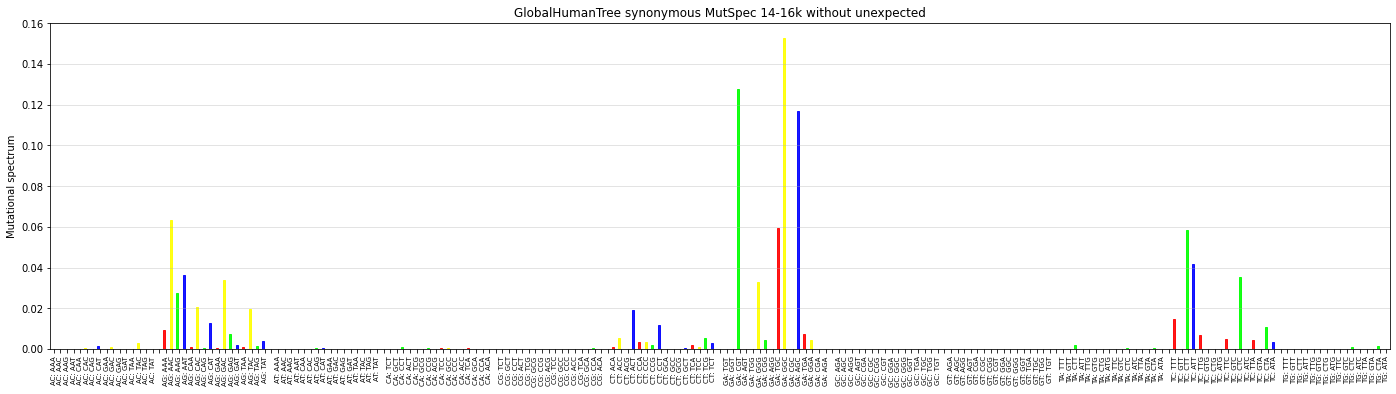

In [20]:
pmin, pmax = 14000, 16000

exp_muts12, exp_muts192 = get_exp_mut_freqs_syn(pmin, pmax)
# replace 'ref_pos' to "position"
obs_muts = muts_filtered[(muts_filtered.ref_pos >= pmin) & (muts_filtered.ref_pos <= pmax) & (muts_filtered.is_leaf == 1)]
print("Number of mutations:", obs_muts.shape[0])
ms12 = calculate_mutspec(obs_muts, exp_muts12)
ms192 = calculate_mutspec(obs_muts, exp_muts192, use_context=True)

ms12.to_csv(f"../data/processed/GlobalHumanTree/mutspec12syn_leaves{pmin//1000}-{pmax//1000}k.csv", index=None)
ms192.to_csv(f"../data/processed/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k.csv", index=None)

plot_mutspec12(ms12, title=f"GlobalHumanTree synonymous MutSpec {pmin//1000}-{pmax//1000}k", 
    savepath=f"../figures/GlobalHumanTree/mutspec12syn_leaves{pmin//1000}-{pmax//1000}k.pdf")
plot_mutspec192kk(ms192, title=f"GlobalHumanTree synonymous MutSpec {pmin//1000}-{pmax//1000}k", 
    filepath=f"../figures/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k.pdf")

ms192["RawMutSpec"] = (ms192["ObsFr"] / ms192["ExpFr"]).fillna(0).replace(np.inf, 0)
ms192["MutSpec"] = ms192["RawMutSpec"] / ms192["RawMutSpec"].sum()
plot_mutspec192kk(ms192, title=f"GlobalHumanTree synonymous MutSpec {pmin//1000}-{pmax//1000}k without unexpected",
    filepath=f"../figures/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k_without_unexpected.pdf")